In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

from tqdm import tqdm

import math

In [2]:
gpu = torch.cuda.is_available()
gpu = False
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cpu


In [3]:
batch_size = 128
torch.manual_seed(50)

In [4]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)

if not os.path.exists('results'):
    os.mkdir('results')

kwargs = {'num_workers': 1, 'pin_memory': True} if device.type == "cuda:0" else {}
trainset = datasets.MNIST(root='./data', train=True,
                          download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size,
                          shuffle=True, **kwargs)

testset = datasets.MNIST(root='./data', train=False,
                          download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size,
                         shuffle=False, **kwargs)

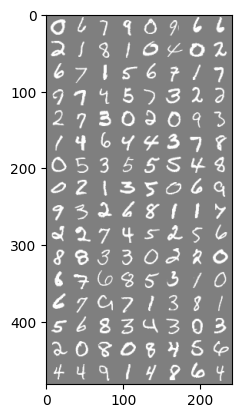

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [6]:
class ConvLayer(nn.Conv2d):
    """
    Serves as a convolutional layer in the Diffusion NN

    Args:
        x: (batch_size, C_in, H, W)
    Returns:
        y: (batch_size, C_out, H, W)
    """
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, dilation=1, groups=1, bias=True):
        
        padding = kernel_size // 2 * dilation
        
        super().__init__(in_channels, out_channels, kernel_size, padding=padding,
                         stride=stride, dilation=dilation, groups=groups, bias=bias)
        
        self.group_norm = nn.GroupNorm(8, out_channels)
        self.activation_fn = nn.SiLU()
        
    def forward(self, x, t):
            x = x + t
            temp = x
            x = super(ConvLayer, self).forward(x)
            x = temp + x
            x = self.group_norm(x)
            x = self.activation_fn(x)
            return x

In [7]:
class DiffusionNet(nn.Module):
    def __init__(self, T_steps=1000, image_size=[1, 28, 28], hidden_dims=[256, 256], temb_dim=256):
        super().__init__()
        self.device = device
        self.T=T_steps
        self.img_C, self.img_H, self.img_W = image_size
        self.hidden_dims = hidden_dims
        self.temb_dim = temb_dim

        self.betas = torch.linspace(0.0001, 0.02, T_steps).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bars = self.alphas.cumprod(0)

        
        # input layer
        self.in_conv1 = nn.Conv2d(in_channels=self.img_C, out_channels=hidden_dims[0], kernel_size=7, padding=3)
        
        # time embedding layer
        self.t_layer1 = nn.Conv2d(in_channels=temb_dim, out_channels=hidden_dims[0], kernel_size=1, padding=0)
        self.t_layer2 = nn.SiLU()
        self.t_layer3 = nn.Conv2d(in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=1, padding=0)
        
        # middle layers
        self.mid_conv1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv_layers = nn.ModuleList([])
        for i in range(1, len(hidden_dims)):
            self.conv_layers.append(ConvLayer(hidden_dims[i-1], hidden_dims[i], kernel_size=3, dilation=3**((i-1)//2)))
        
        # output layer
        self.out_conv1 = nn.Conv2d(in_channels=256, out_channels=self.img_C, kernel_size=3, padding=1)
    
    def forward(self, x, t):
        
        # embedding
        t_embedding = self.pos_encoding(t, self.temb_dim)
        t_embedding = self.t_layer2(self.t_layer1(t_embedding.unsqueeze(-1).unsqueeze(-2)))
        t_embedding = self.t_layer3(t_embedding)

        # input layer
        x = self.in_conv1(x)
        
        # second layer (first mid layer, no activation func)
        x = x + t_embedding
        temp = x
        x = self.mid_conv1(x)
        x = temp + x
        
        # middle layers
        for i in range(len(self.conv_layers)):
            x = self.conv_layers[i](x, t_embedding)
        
        # output layer
        x = self.out_conv1(x)

        return x
        
    # scale to -1 to 1, crucial according to DDPM paper.
    def minus_one_one(self, x):
        return x * 2 - 1
    
    def zero_one(self, x):
        return (x + 1) * 0.5

    # function for time embedding, used in the forward part of the NN
    def pos_encoding(self, t, channels):
        device = t.device
        half_dim = channels // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb
    
    # add noise
    def add_noise(self, X, t):
        X = self.minus_one_one(X)
        epsilon = torch.normal(0., 1., size=X.shape).to(self.device)
        
        alpha_bar = self.alpha_bars[t][:, None, None, None]
        noisy_sample = X * torch.sqrt(alpha_bar) + epsilon * torch.sqrt(1 - alpha_bar)
        return noisy_sample
        
    
    # loss function
    def loss(self, X):
        X = self.minus_one_one(X)
        ts = torch.randint(self.T, size=(X.shape[0],)).to(device) # pick t uniformly at random
        alpha = self.alpha_bars[ts][:, None, None, None]
        epsilon = torch.normal(0., 1., size=X.shape).to(device)
        samples = torch.sqrt(alpha)*X + torch.sqrt(1-alpha)*epsilon
        eps_model = self.forward(samples, ts)
        return nn.functional.mse_loss(eps_model, epsilon)
        
    # function to generate samples
    def sample(self, num):
        X = torch.normal(0.0, 1.0, size=(num, self.img_C, self.img_H, self.img_W), dtype=torch.float32).to(device)
        
        for t in reversed(range(self.T)):
            timestep = torch.tensor([t]).repeat(num).to(self.device)

            if t > 1:
              z = torch.randn_like(X).to(self.device)
            else:
              z = torch.zeros_like(X).to(self.device)
            beta = self.betas[timestep][:, None, None, None]
            alpha = self.alphas[timestep][:, None, None, None]
            alpha_bar = self.alpha_bars[timestep][:, None, None, None]
            eps_model = self.forward(X, timestep)
            X = 1 / torch.sqrt(alpha) * (X - (1 - alpha) / torch.sqrt(1 - alpha_bar) * eps_model) + z * torch.sqrt(beta)
        X = self.zero_one(X.clamp(-1, 1))
        return X

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n_layers = 8
hidden_dim = 256
hidden_dims = [hidden_dim for _ in range(n_layers)]

num_epochs = 200
lr = 5e-5

model = DiffusionNet(hidden_dims=hidden_dims).to(device)
print("Number of model parameters: ", count_parameters(model))
print(model)

Number of model parameters:  4870913
DiffusionNet(
  (in_conv1): Conv2d(1, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (t_layer1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
  (t_layer2): SiLU()
  (t_layer3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
  (mid_conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layers): ModuleList(
    (0-1): 2 x ConvLayer(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (group_norm): GroupNorm(8, 256, eps=1e-05, affine=True)
      (activation_fn): SiLU()
    )
    (2-3): 2 x ConvLayer(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), dilation=(3, 3)
      (group_norm): GroupNorm(8, 256, eps=1e-05, affine=True)
      (activation_fn): SiLU()
    )
    (4-5): 2 x ConvLayer(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(9, 9), dilation=(9, 9)
      (group_norm): GroupNorm(8, 256, eps=1e-05, affine=True)
      (activation_fn): SiLU()
    )


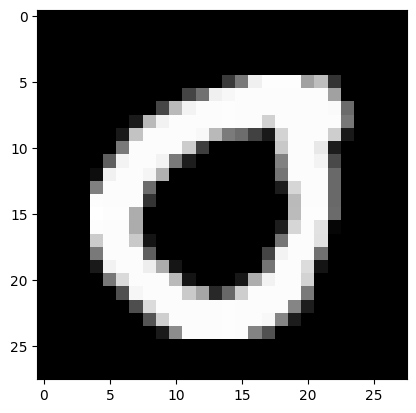

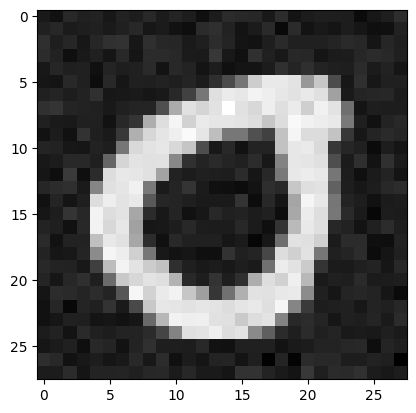

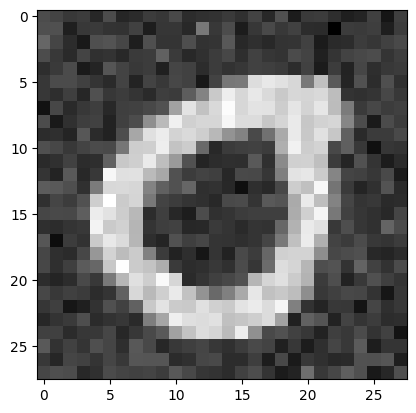

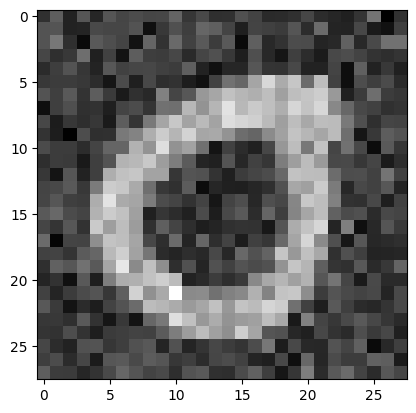

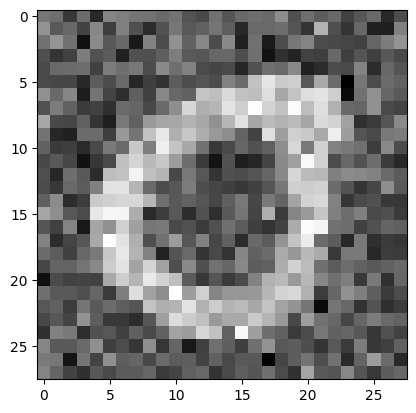

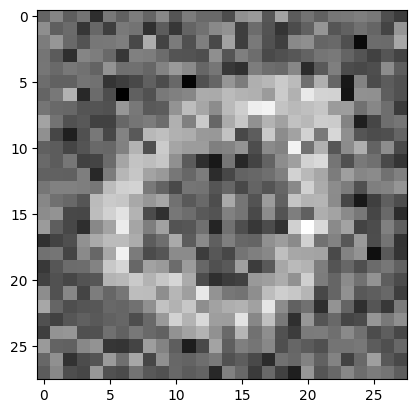

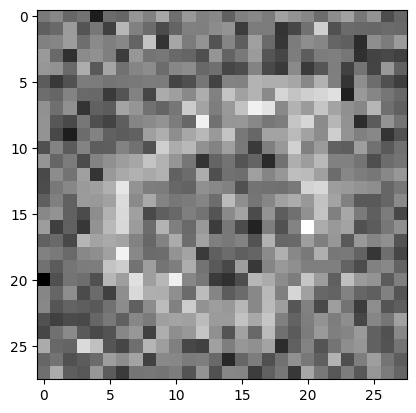

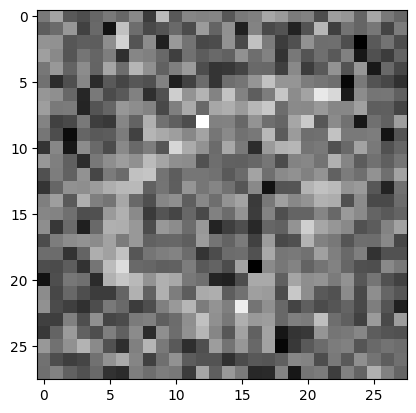

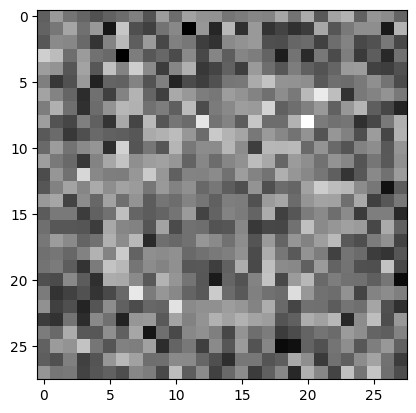

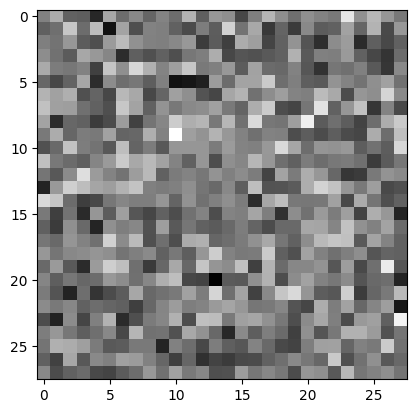

In [10]:
# lets check if the forward process works!
image = images[0]

lst = []
lst.append(image)
for t in range(model.T):
    ts = torch.randint(low=t, high=t+1, size=(image.shape[0], )).to(device)
    temp = model.add_noise(lst[t].to(device), ts)
    temp = model.zero_one(temp)
    lst.append(temp)

for i in range(100):
    if i % 10 == 0:
        plt.imshow(lst[i][0].squeeze().detach().cpu().numpy(), cmap='gray')
        plt.show()

In [11]:
# train or load pre-trained model
train_ = False

#train loop
if train__:
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for e in range(1, num_epochs+1):
        train_loss = 0.
        train_loss_vals = []
        for batch_idx, (x, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
            x = x.to(device)
            optimizer.zero_grad()
            l = model.loss(x)
            l.backward()
            train_loss += l.item()
            train_loss_vals.append(train_loss)
            optimizer.step()
        print("\tEpoch,", e, "complete!", "\tLoss: ", train_loss / batch_idx)
else:
    model.load_state_dict(torch.load('./trained_models/diffusion_model'))

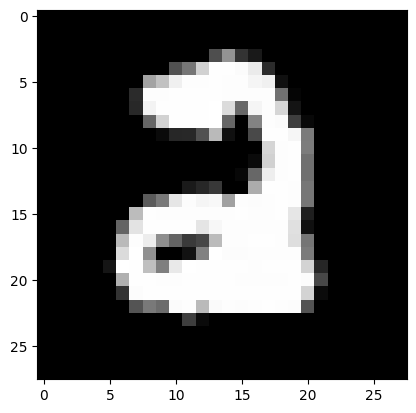

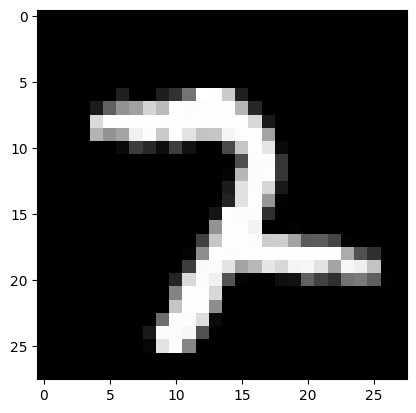

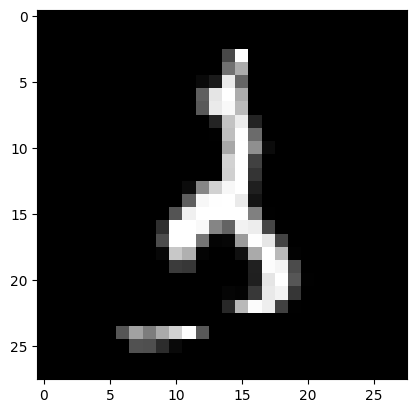

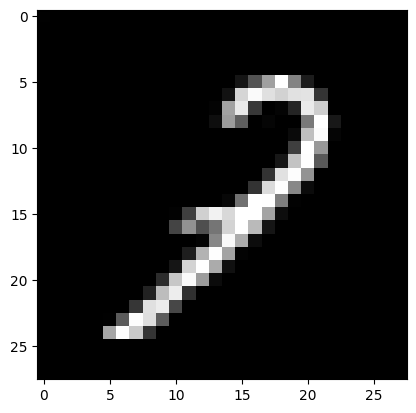

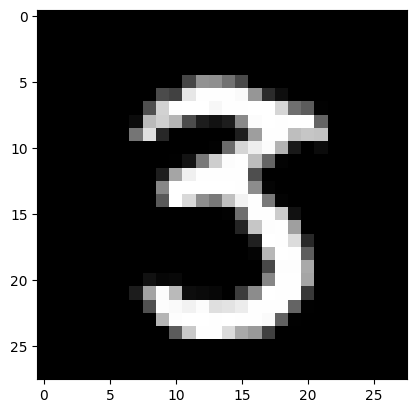

In [12]:
# generate some images (takes long time if no gpu)
model.eval()
with torch.no_grad():
    generated_images = model.sample(5)

for i in range(len(generated_images)):
  plt.imshow(generated_images[i][0].squeeze().detach().cpu().numpy(), cmap='gray')
  plt.show()    

In [14]:
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(torchvision.utils.make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

In [15]:
# draw_sample_image(generated_images, "Generated Images")

In [ ]:
# draw_sample_image(x[:64], "Ground-truth Images")